# WoFS Precipitation Histograms

## Setup

In [3]:
# Import statement
import xarray as xr
from typing import List
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scienceplots # noqa: F401

plt.style.use(["science", "nature"])
plt.rcParams["text.usetex"] = True


In [4]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded

def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})

# Function to overwrite ne values
def overwrite_ne(da:xr.DataArray|xr.Dataset) -> xr.DataArray|xr.Dataset:
    da["ne"] = range(5)
    return(da)

# Function to format the x-tick labels to two decimal points
def two_decimal_formatter(x, pos):
    return f"{x:.2f}"


In [5]:
# Load in 20-23 UTC initializations
wofs_all = [get_wofs_all(i) for i in [20, 21, 22, 23]]

# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


## Calculate 0100-0200 UTC rainfall

In [6]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)


In [7]:
# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]

wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all))]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all))]

In [8]:
# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init")
init = init.assign_coords({"init": init})

rain12_wet = (
    xr.concat([overwrite_ne(w.rain) for w in wofs_wet], dim=init)  # type:ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .max(dim=["lat", "lon"])
    .chunk("auto")
    .stack(run=("init", "ne"))
)
rain12_dry = (
    xr.concat([overwrite_ne(w.rain) for w in wofs_dry], dim=init)  # type: ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .max(dim=["lat", "lon"])
    .chunk("auto")
    .stack(run=("init", "ne"))
)

## Plot Histograms

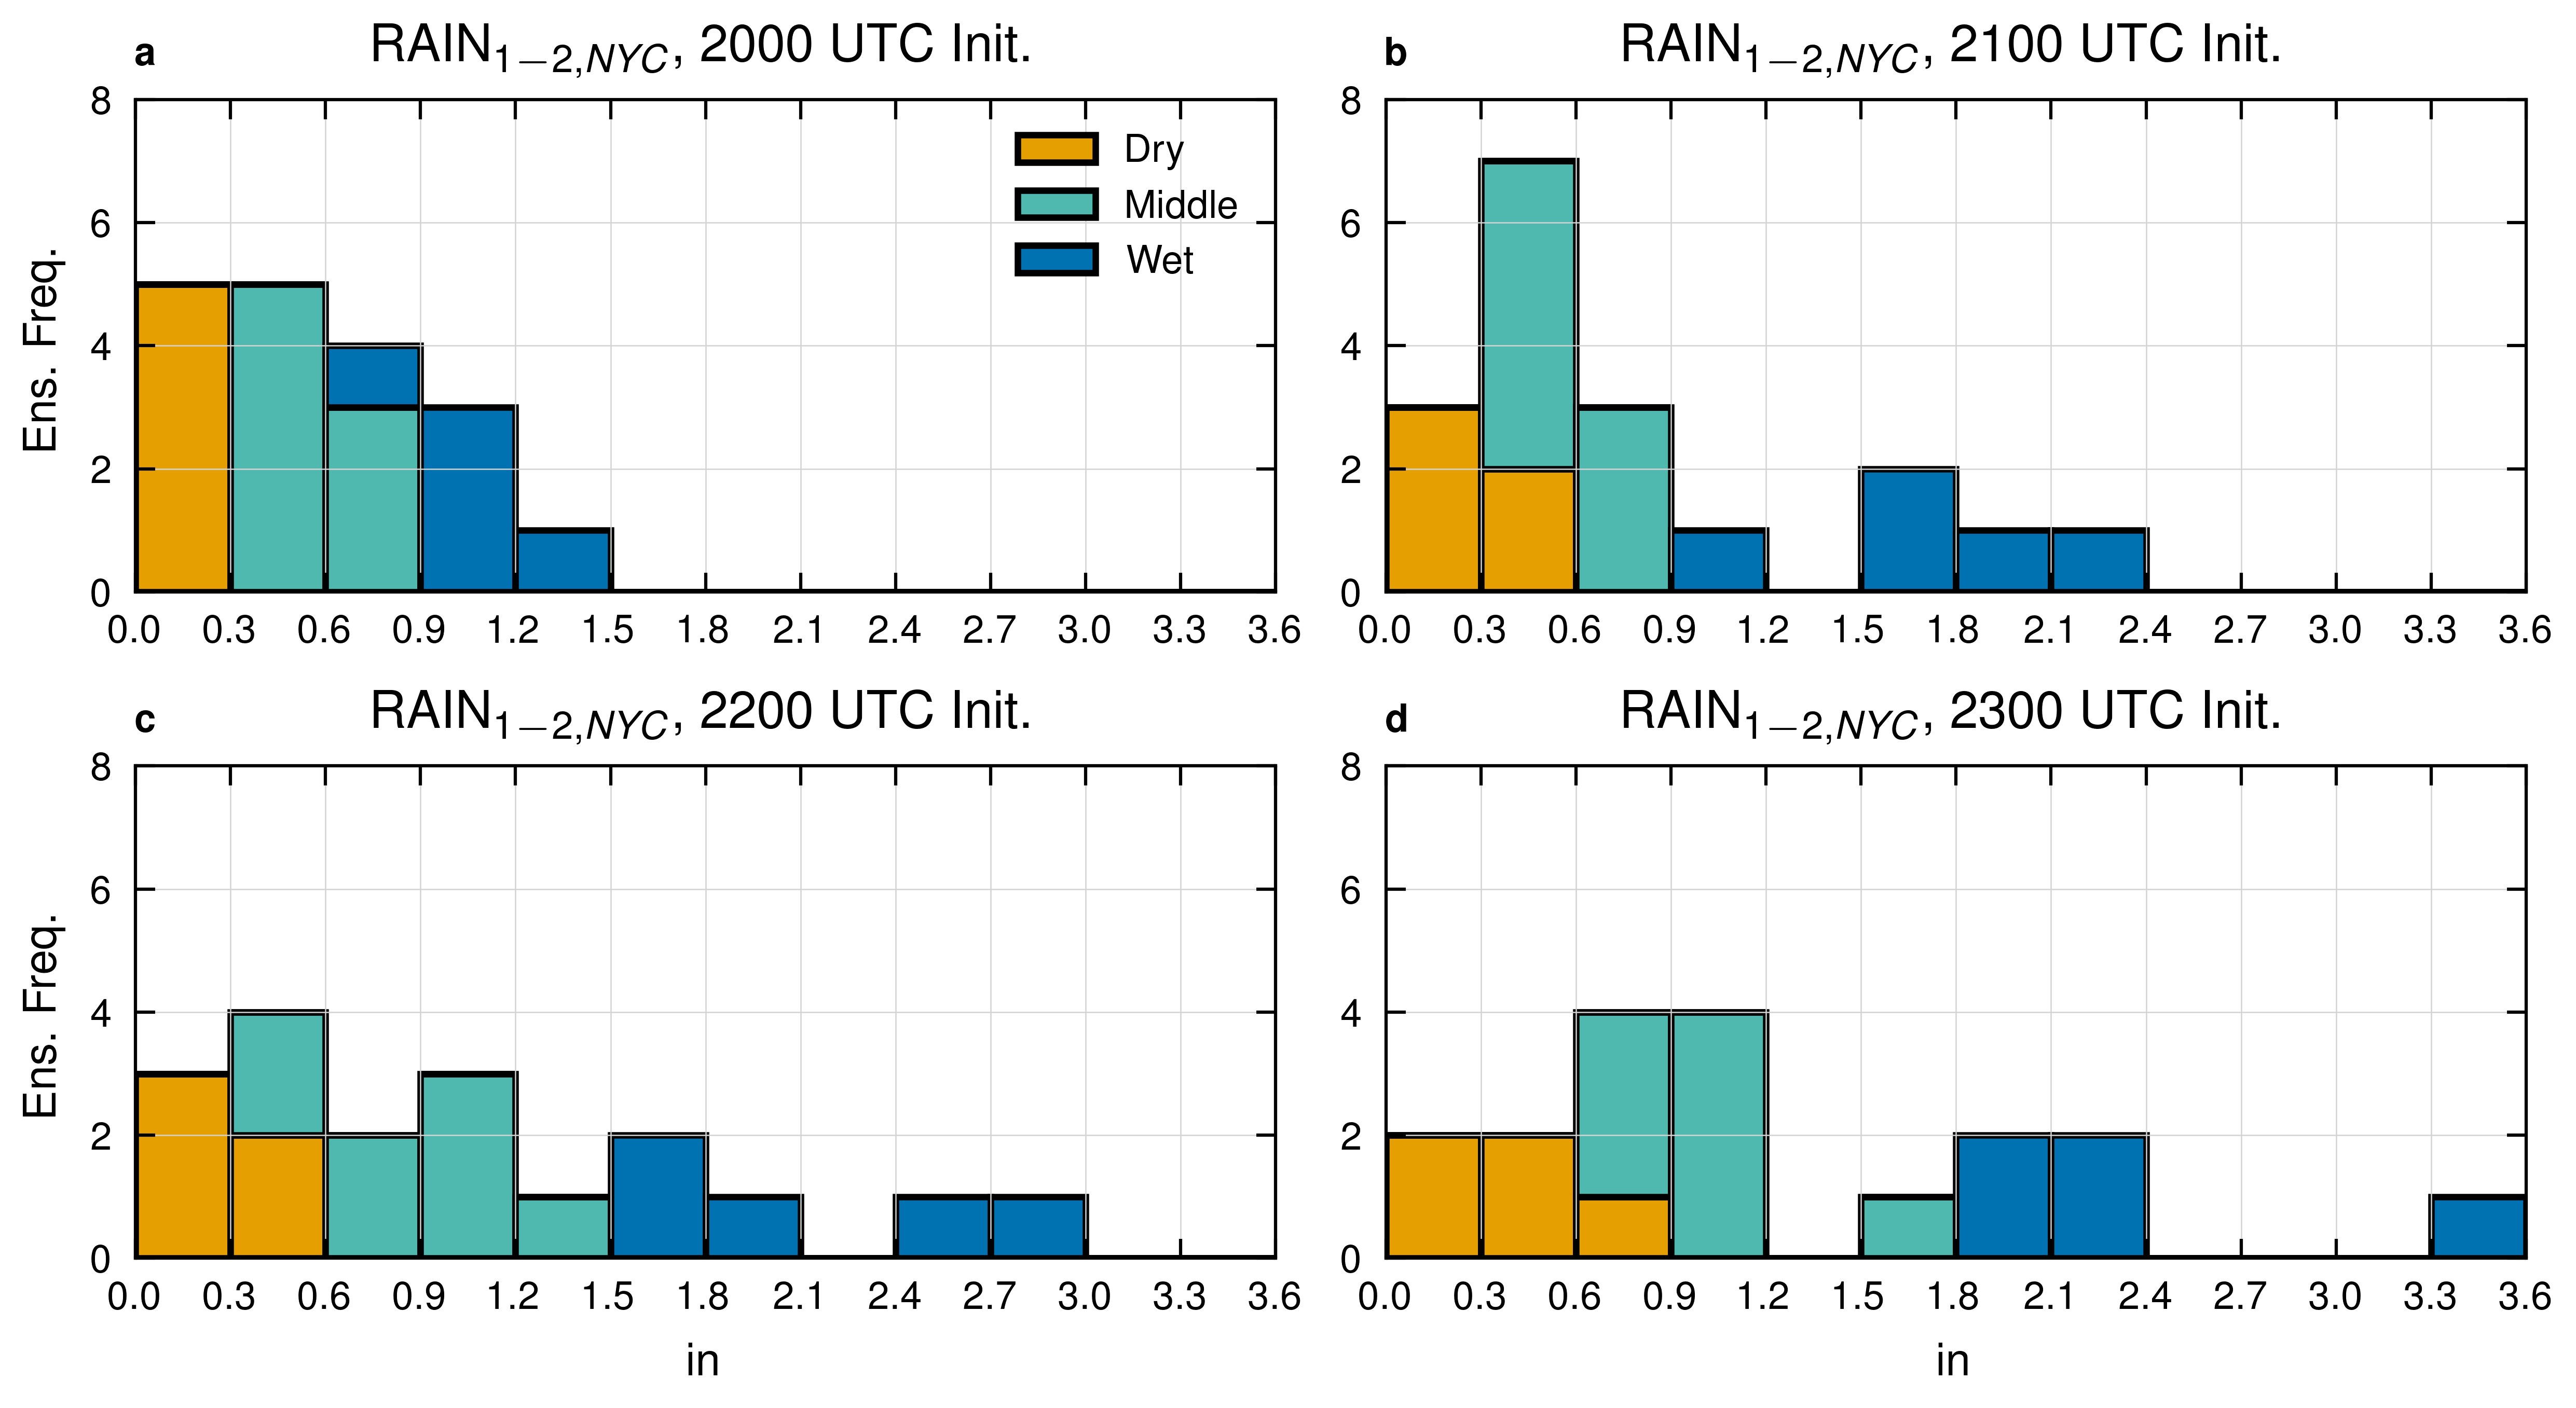

In [22]:
titles = [
    "RAIN$_{1-2,NYC}$, 2000 UTC Init.",
    "RAIN$_{1-2,NYC}$, 2100 UTC Init.",
    "RAIN$_{1-2,NYC}$, 2200 UTC Init.",
    "RAIN$_{1-2,NYC}$, 2300 UTC Init.",
]

bins = np.arange(0, 3.7, 0.3)


# Create the figure and axes
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
    dpi=900,
    figsize=(5.5, 3),
    layout="constrained",
)

# Define bar width
bar_width = (bins[1] - bins[0]) / 1

# Loop through each initialization
for i, ax in enumerate(axes.flatten()):
    # Extract data for the current initialization
    new_data = rain12_aoi.isel(init=i).values

    # Compute histogram
    hist, _ = np.histogram(new_data, bins=bins)

    # Calculate cumulative sums
    cumsum = np.cumsum(hist)

    # Define cumulative thresholds
    magenta_threshold = 5
    cyan_threshold = 13

    # Initialize magenta, cyan, and limegreen bars
    magenta = np.zeros_like(hist, dtype=float)
    cyan = np.zeros_like(hist, dtype=float)

    # Fill magenta bars
    for j, val in enumerate(cumsum):
        if val <= magenta_threshold:
            magenta[j] = hist[j]
        elif cumsum[j - 1] < magenta_threshold <= val:
            magenta[j] = magenta_threshold - cumsum[j - 1]
            end_magenta_value = magenta[j]
            break

    # Fill cyan bars
    for j, val in enumerate(cumsum):
        if magenta_threshold < val <= cyan_threshold:
            if cumsum[j - 1] < magenta_threshold:
                cyan[j] = hist[j] - end_magenta_value
            else:
                cyan[j] = hist[j]
        elif cumsum[j - 1] < cyan_threshold <= val:
            cyan[j] = cyan_threshold - cumsum[j - 1]
            break

    # Assign remaining values to limegreen
    limegreen = np.zeros_like(hist, dtype=float)
    for j in range(len(hist)):
        limegreen[j] = max(
            hist[j] - magenta[j] - cyan[j], 0
        )  # Ensure no negative or extra values

    # Plot the bars
    bar_width = (bins[1] - bins[0]) / 1

    ax.bar(
        bins[:-1],
        magenta,
        width=bar_width,
        align="edge",
        color="#E69F00",
        edgecolor="black",
        label="Dry",
    )
    ax.bar(
        bins[:-1],
        cyan,
        width=bar_width,
        align="edge",
        bottom=magenta,
        color="#4fb9af",
        edgecolor="black",
        label="Middle",
    )
    ax.bar(
        bins[:-1],
        limegreen,
        width=bar_width,
        align="edge",
        bottom=magenta + cyan,
        color="#0072B2",
        edgecolor="black",
        label="Wet",
    )

    # formatting
    ax.xaxis.set_tick_params(which="both", labelbottom=True)
    ax.tick_params(axis="both", labelsize=6)
    ax.set_xticks(bins)
    ax.set_yticks(range(0, 9, 2))
    ax.yaxis.set_tick_params(which="both", labelleft=True)
    ax.grid(color="lightgray", linewidth=0.2)
    ax.set_title(titles[i], fontsize=8)
    ax.set_xlabel("")
    ax.minorticks_off()

    if i % 2 == 0:
        ax.set_ylabel("Ens. Freq.", fontsize=7)

# Set x-labels for the bottom row
axes[1, 0].set_xlabel("in", fontsize=7)
axes[1, 1].set_xlabel("in", fontsize=7)
axes[0, 0].legend(loc="upper right", fontsize=6)

# Set x-limits
plt.xlim(bins.min(), bins.max())

# Add a global title
# plt.suptitle("0100 UTC NYC rainfall", fontsize=9)

letters = ["a", "b", "c", "d"]
for i, ax in enumerate(axes.flatten()):
    ax.text(
        -0, 1.07, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=6
    )

# Show the plot
# plt.show()
plt.savefig("../final-figures/rainfall-histogram.pdf", bbox_inches="tight")

plt.show()


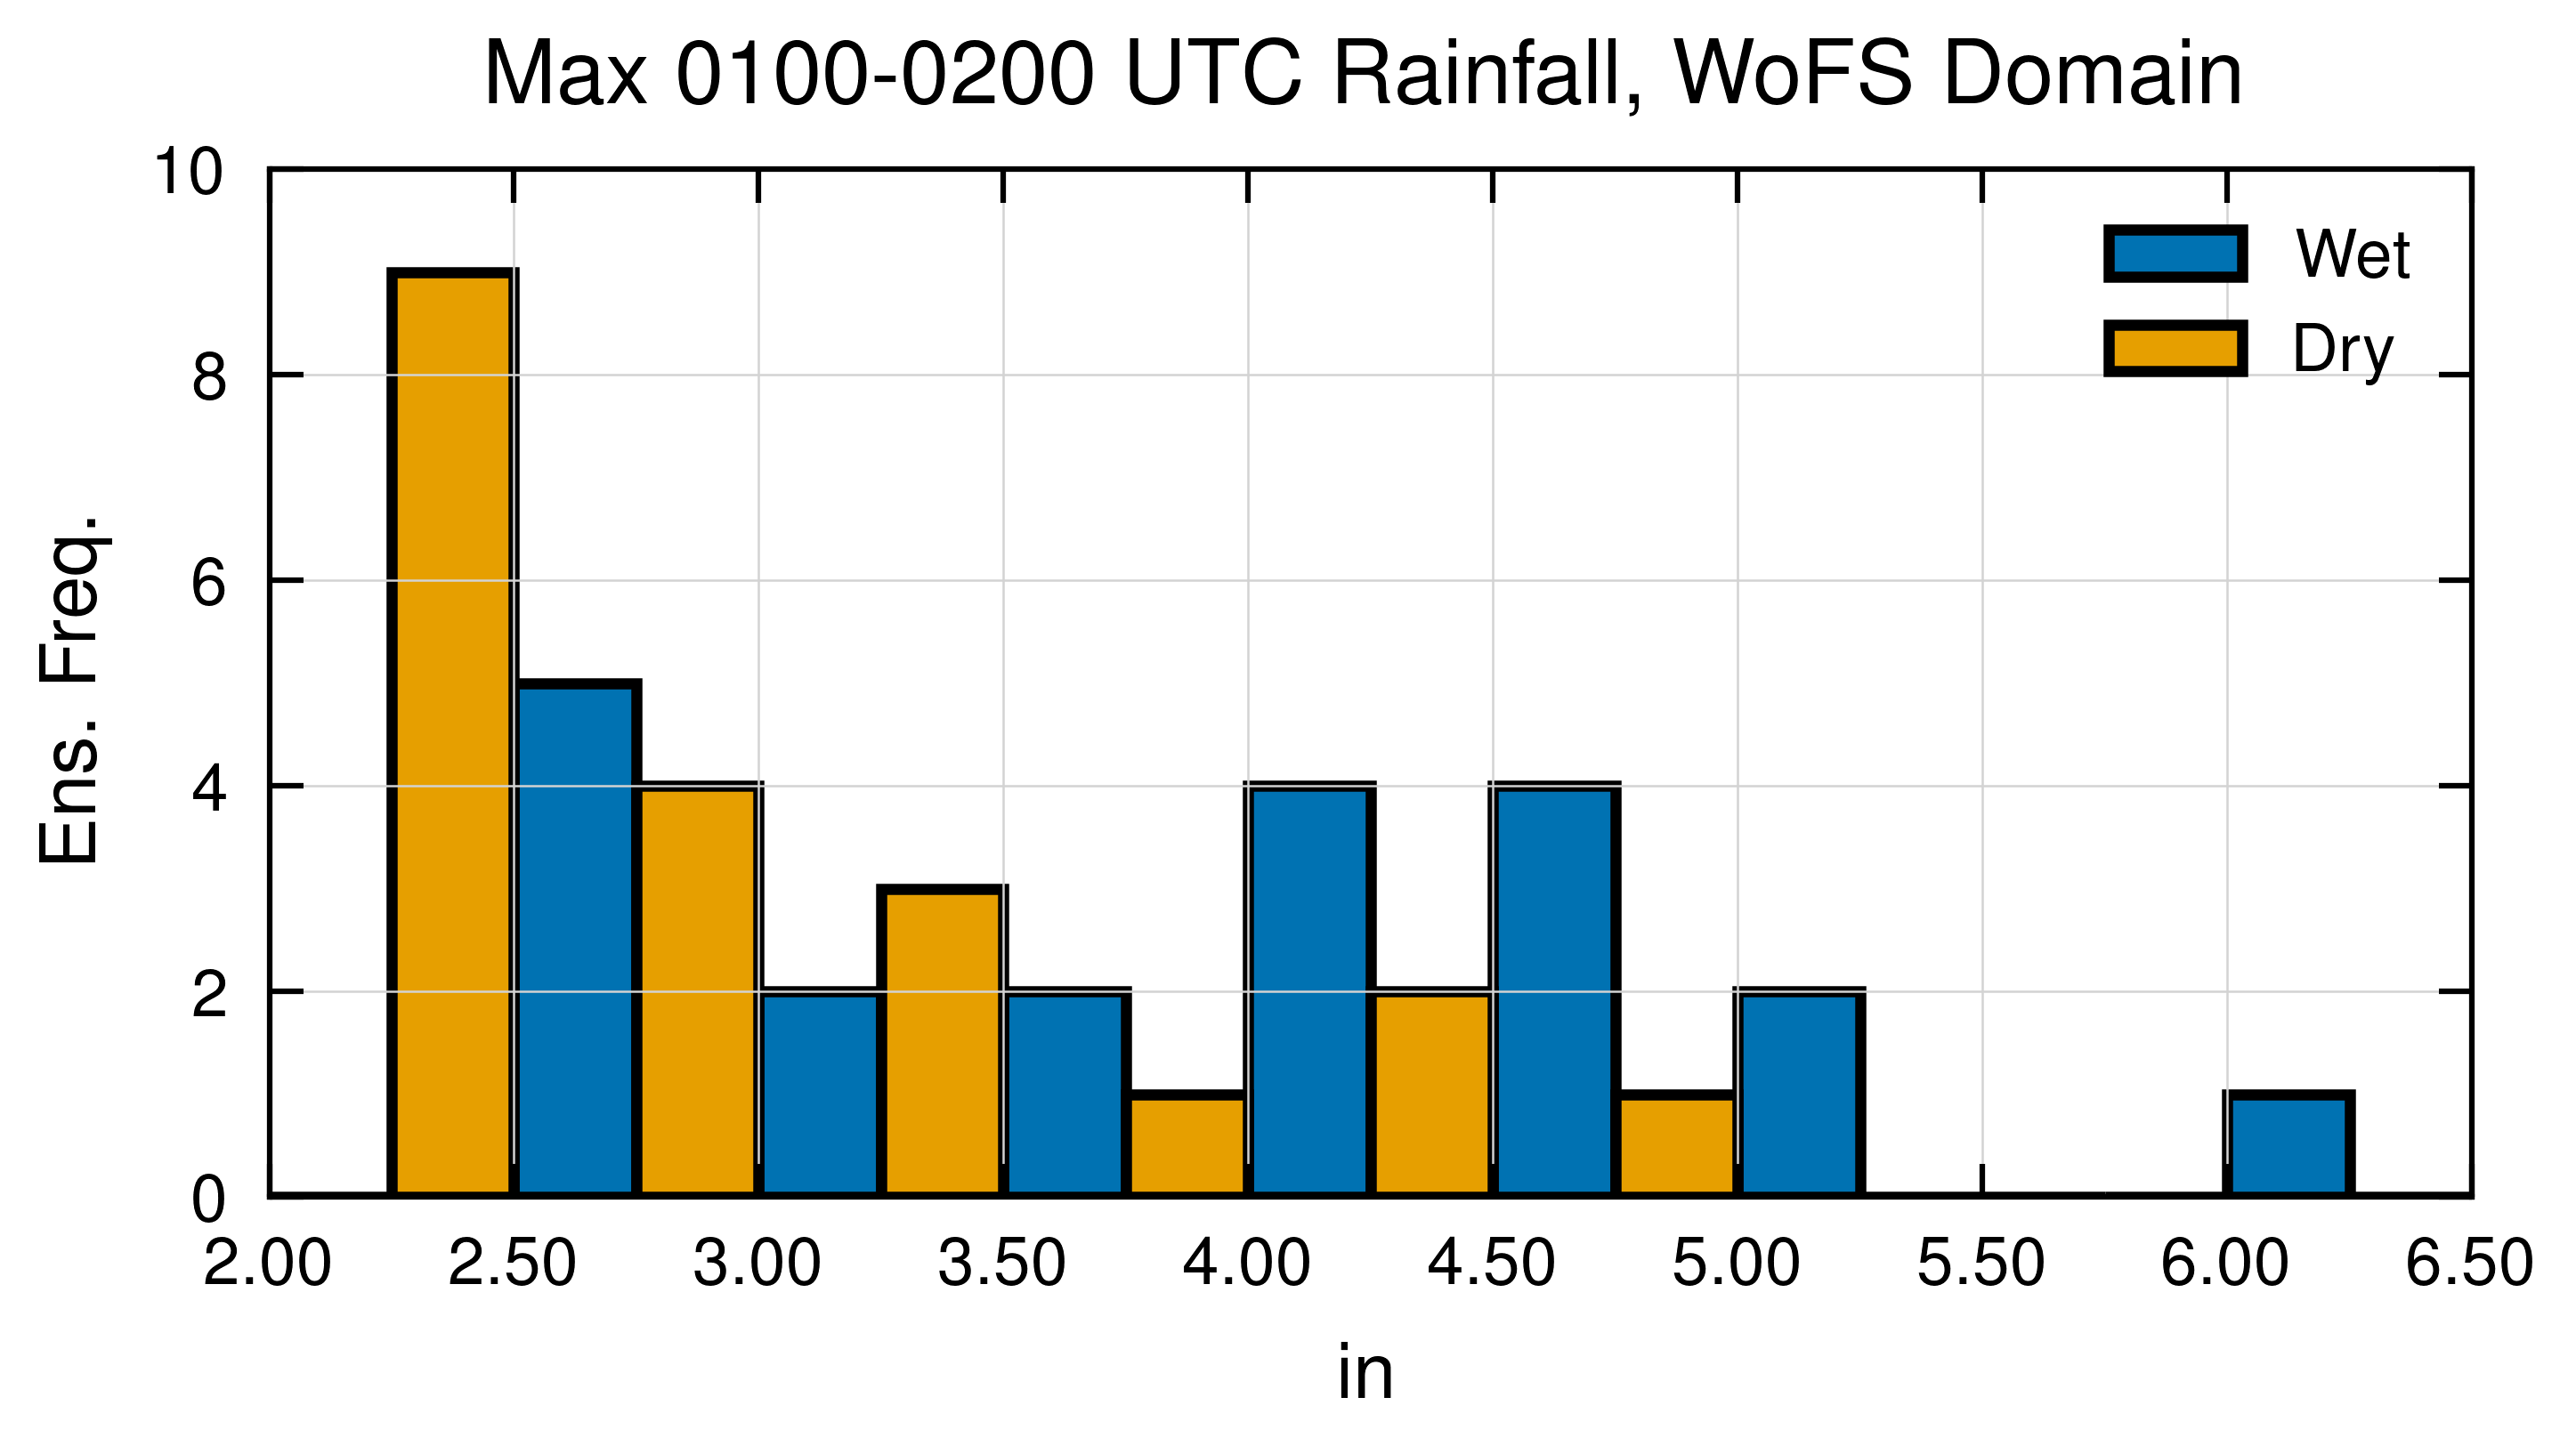

In [20]:
bins = np.arange(2, 6.6, 0.5)

# Make a list of titles
title = "Max 0100-0200 UTC Rainfall, WoFS Domain"


# Make a 1 x 1 figure with a histogram of 1-2 UTC rainfall for each initialization
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=True,
    sharey=True,
    dpi=900,
    figsize=(3.2, 1.8),
    layout="constrained",
)

# Width for the bars in the histograms
bar_width = (bins[1] - bins[0]) / 2

# Extract the data for the current initialization
wet_data = rain12_wet.values
dry_data = rain12_dry.values

# Compute the histogram
wet_hist, _ = np.histogram(wet_data, bins=bins)
dry_hist, _ = np.histogram(dry_data, bins=bins)

# Plot the histograms
ax.bar(
    bins[:-1],
    wet_hist,
    width=bar_width,
    align="edge",
    edgecolor="black",
    color="#0072B2",
    label="Wet",
)
ax.bar(
    bins[:-1] + bar_width,
    dry_hist,
    width=bar_width,
    align="edge",
    edgecolor="black",
    color="#E69F00",
    label="Dry",
)

ax.xaxis.set_tick_params(which="both", labelbottom=True)
ax.tick_params(axis="both", labelsize=6)
ax.set_xticks(bins)
ax.set_yticks(range(0, 12, 2))
ax.yaxis.set_tick_params(which="both", labelleft=True)
ax.grid(color="lightgray", linewidth=0.2)
ax.set_title(title, fontsize=8)
ax.set_xlabel("")
ax.minorticks_off()

# Set the x-axis formatter to round to two decimal points
ax.xaxis.set_major_formatter(FuncFormatter(two_decimal_formatter))

ax.set_ylabel("Ens. Freq.", fontsize=7)

# Set the x-axis labels for the bottom row of plots
ax.set_xlabel("in", fontsize=7)

# Set the x-axis limit
plt.xlim(bins.min(), bins.max())

# Add a legend to the plot
ax.legend(fontsize=6)

plt.savefig("../final-figures/wet_vs_dry_max_rainfall.pdf", bbox_inches="tight")

# Show the plot
plt.show()
